In [1]:
import sys
import time

# Maths things
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Algorithm
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

from functools import partial
from sklearn import preprocessing

In [2]:
data = np.load('regression_data.npy')
target = np.loadtxt('target_values.txt')

In [3]:
error = mean_absolute_error

In [4]:
X_ltrain, X_test, Y_ltrain, Y_test = train_test_split(data, target, test_size = 100, random_state = 7)

In [5]:
from sklearn import preprocessing
X_ltrain = preprocessing.normalize(X_ltrain);
X_test =  preprocessing.normalize(X_test);

In [6]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_ltrain, Y_ltrain, test_size = 100, random_state = 17)

In [7]:
X_train.shape

(554, 27827)

# Feature Selection

## Importance

In [209]:
selector = SelectFromModel(estimator=LinearRegression(),max_features=10000).fit(X_train, Y_train)
selector.estimator_.coef_

#selector.threshold_
#selector.get_support()

selector.transform(X_train);
X_train_redu, X_test_redu = (selector.transform(X_train),selector.transform(X_valid))

In [210]:
%%time
numbers_ft = np.logspace(1,4,50).astype(int)
losses_n_ft = np.zeros((len(numbers_ft)))
for i,n_ft in enumerate(numbers_ft):
    selector = SelectFromModel(estimator=LinearRegression(),threshold=-np.inf,max_features=n_ft)
    selector.fit(X_train, Y_train)
    T_train = selector.transform(X_train)
    T_valid= selector.transform(X_valid)
    lr = LinearRegression()
    lr.fit(T_train, Y_train)
    Y_pred = lr.predict(T_valid)
    loss = error(Y_valid, Y_pred)
    losses_n_ft[i] = loss
    print(n_ft)

10
11
13
15
17
20
23
26
30
35
40
47
54
62
71
82
95
109
126
145
167
193
222
255
294
339
390
449
517
596
686
790
910
1048
1206
1389
1599
1842
2120
2442
2811
3237
3727
4291
4941
5689
6551
7543
8685
10000
CPU times: user 2min 9s, sys: 1.92 s, total: 2min 11s
Wall time: 33.1 s


In [211]:
optimal_index_n_ft = np.unravel_index(losses_n_ft.argmin(), losses_n_ft.shape)
optimal_n_ft = numbers_ft[optimal_index_n_ft]
print("Optimal number of n_pc for PCA using LR is {} ,gives {}".format(optimal_n_ft,losses_n_ft[optimal_index_n_ft]))

Optimal number of n_pc for PCA using LR is 10000 ,gives 0.38966374977675167


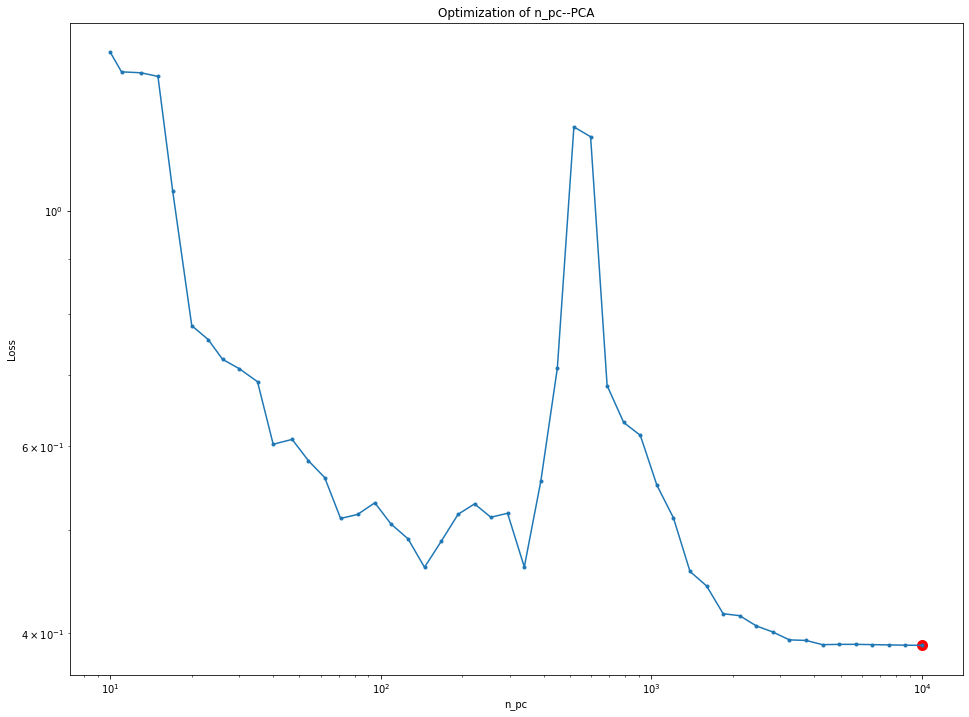

In [212]:
plt.figure(figsize=(16, 12))
plt.plot(numbers_ft,losses_n_ft,'.-')
plt.scatter(optimal_n_ft, losses_n_ft[optimal_index_n_ft], s = 100,marker='o', color='r')
plt.xlabel('n_pc')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Loss')
#plt.legend()
plt.title('Optimization of n_pc--'+'PCA')
plt.show()

# Retrain and Map

In [213]:
n_ft = 100#optimal_n_ft
selector = SelectFromModel(estimator=LinearRegression(),threshold=-np.inf,max_features=n_ft)
selector.fit(X_train, Y_train)
T_ltrain = selector.transform(X_ltrain)
T_train  = selector.transform(X_train)
T_valid  = selector.transform(X_valid)
T_test   = selector.transform(X_test)

# Try different regression models

## Linear Regression

### No need for optimization

### Learning Curve

In [214]:
lr = LinearRegression()
numbers_train = np.arange(54,655,50)
losses_lr = np.zeros((len(numbers_train)))

In [215]:
%%time
for i,n in enumerate(numbers_train):
    Tt_train = T_ltrain[:n]
    Yt_train = Y_ltrain[:n]
    lr.fit(Tt_train,Yt_train)
    Y_pred = lr.predict(T_test)
    loss = error(Y_test, Y_pred)
    losses_lr[i] = loss
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
CPU times: user 110 ms, sys: 4.03 ms, total: 114 ms
Wall time: 28.9 ms


In [216]:
optimal_index_loss_lr = np.unravel_index(losses_lr.argmin(), losses_lr.shape)
optimal_n_train_lr = numbers_train[optimal_index_loss_lr]
min_loss_lr = losses_lr[optimal_index_loss_lr]
print("Minimum loss of LR with importance is {} when number of train is {}  ".format(min_loss_lr,optimal_n_train_lr))

Minimum loss of LR with importance is 0.5421976108024668 when number of train is 654  


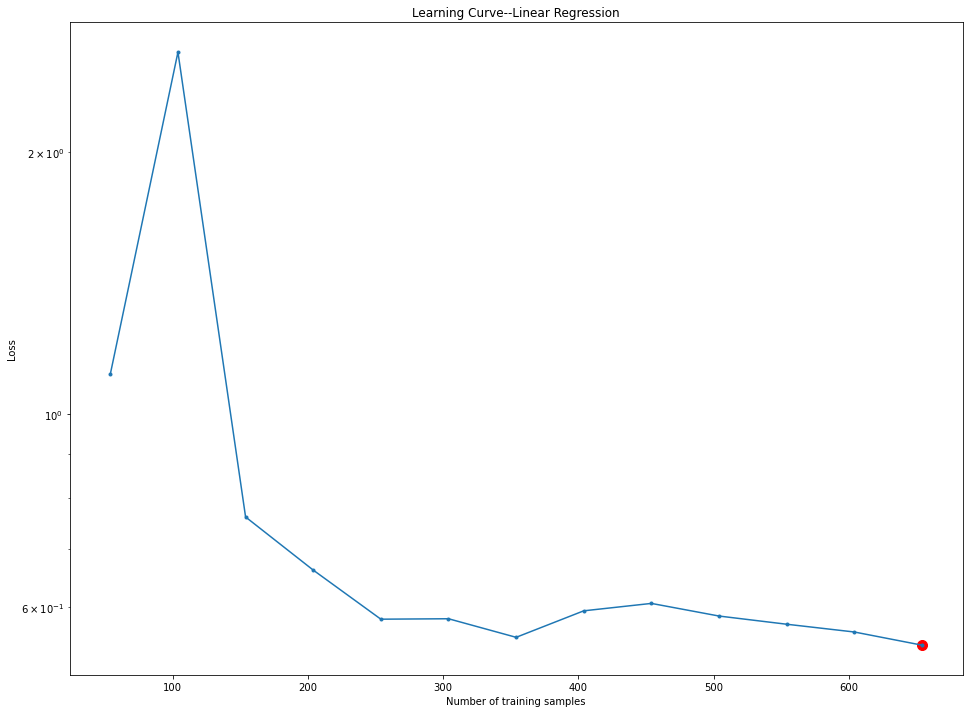

In [217]:
plt.figure(figsize=(16, 12))
plt.plot(numbers_train,losses_lr,'.-')
plt.scatter(optimal_n_train_lr, min_loss_lr, s = 100,marker='o', color='r')
plt.xlabel('Number of training samples')
plt.yscale('log')
plt.ylabel('Loss')
#plt.legend()
plt.title('Learning Curve--'+'Linear Regression')
plt.show()

## Ridge Regression

### Optimization

#### Optimization of alpha

In [218]:
%%time
alphas =  np.logspace(-10, 1, 23)
losses_rr_alpha = np.zeros((len(alphas)))
for i,alpha in enumerate(alphas):
    rr = Ridge(alpha = alpha)
    rr.fit(T_train, Y_train)
    Y_pred = rr.predict(T_valid)
    loss = error(Y_valid, Y_pred)
    losses_rr_alpha[i] = loss
    print(alpha)

1e-10
3.1622776601683795e-10
1e-09
3.1622776601683795e-09
1e-08
3.162277660168379e-08
1e-07
3.162277660168379e-07
1e-06
3.162277660168379e-06
1e-05
3.1622776601683795e-05
0.0001
0.00031622776601683794
0.001
0.0031622776601683794
0.01
0.03162277660168379
0.1
0.31622776601683794
1.0
3.1622776601683795
10.0
CPU times: user 116 ms, sys: 7.94 ms, total: 124 ms
Wall time: 31.1 ms


In [219]:
optimal_index_alpha_rr = np.unravel_index(losses_rr_alpha.argmin(), losses_rr_alpha.shape)
optimal_alpha_rr = alphas[optimal_index_alpha_rr]
print("Optimal alpha for RR with importance is {} ".format(optimal_alpha_rr))

Optimal alpha for RR with importance is 1e-05 


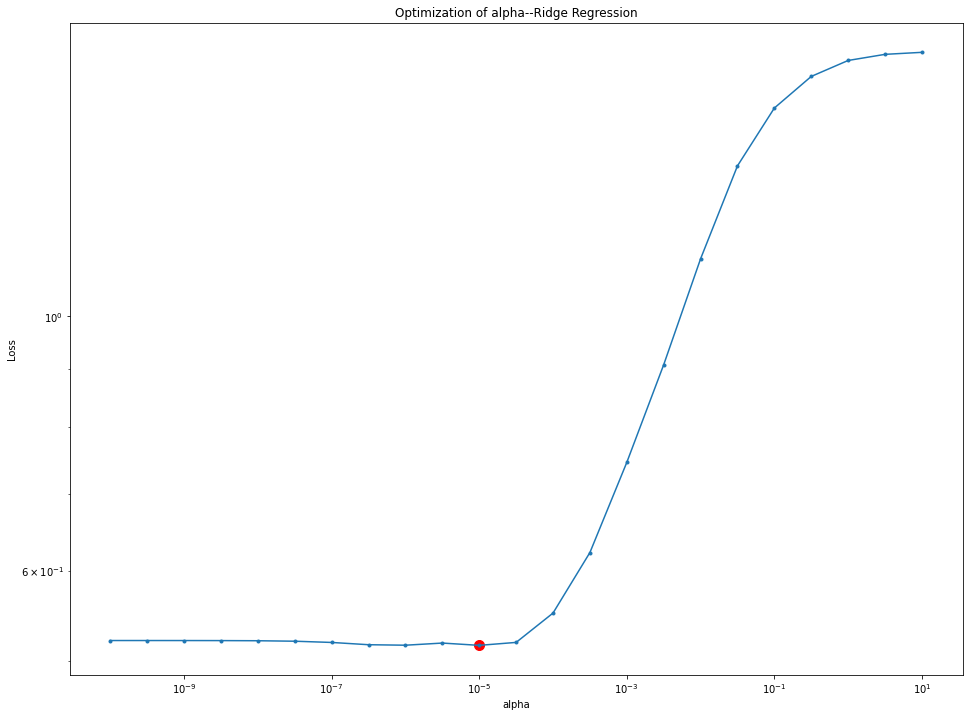

In [220]:
plt.figure(figsize=(16, 12))
plt.plot(alphas,losses_rr_alpha,'.-')
plt.scatter(optimal_alpha_rr, losses_rr_alpha[optimal_index_alpha_rr], s = 100,marker='o', color='r')
plt.xlabel('alpha')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Loss')
#plt.legend()
plt.title('Optimization of alpha--'+'Ridge Regression')
plt.show()

### Learning Curve

In [221]:
best_rr = Ridge(alpha = optimal_alpha_rr)
numbers_train = np.arange(54,655,50)
losses_rr = np.zeros((len(numbers_train)))

In [222]:
%%time
for i,n in enumerate(numbers_train):
    Tt_train = T_ltrain[:n]
    Yt_train = Y_ltrain[:n]
    best_rr.fit(Tt_train,Yt_train)
    Y_pred = best_rr.predict(T_test)
    loss = error(Y_test, Y_pred)
    losses_rr[i] = loss
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
CPU times: user 63.3 ms, sys: 0 ns, total: 63.3 ms
Wall time: 16 ms


In [223]:
losses_rr

array([0.94503391, 0.72490131, 0.6697411 , 0.6633872 , 0.63706324,
       0.58422947, 0.60246206, 0.6384934 , 0.6378458 , 0.62459231,
       0.60766331, 0.60182371, 0.58308541])

In [224]:
optimal_index_loss_rr = np.unravel_index(losses_rr.argmin(), losses_rr.shape)
optimal_n_train_rr = numbers_train[optimal_index_loss_rr]
min_loss_rr = losses_rr[optimal_index_loss_rr]
print("Minimum loss of RR with Pimportance is {} when number of train is {}  ".format(min_loss_rr,optimal_n_train_rr))

Minimum loss of RR with Pimportance is 0.5830854120723855 when number of train is 654  


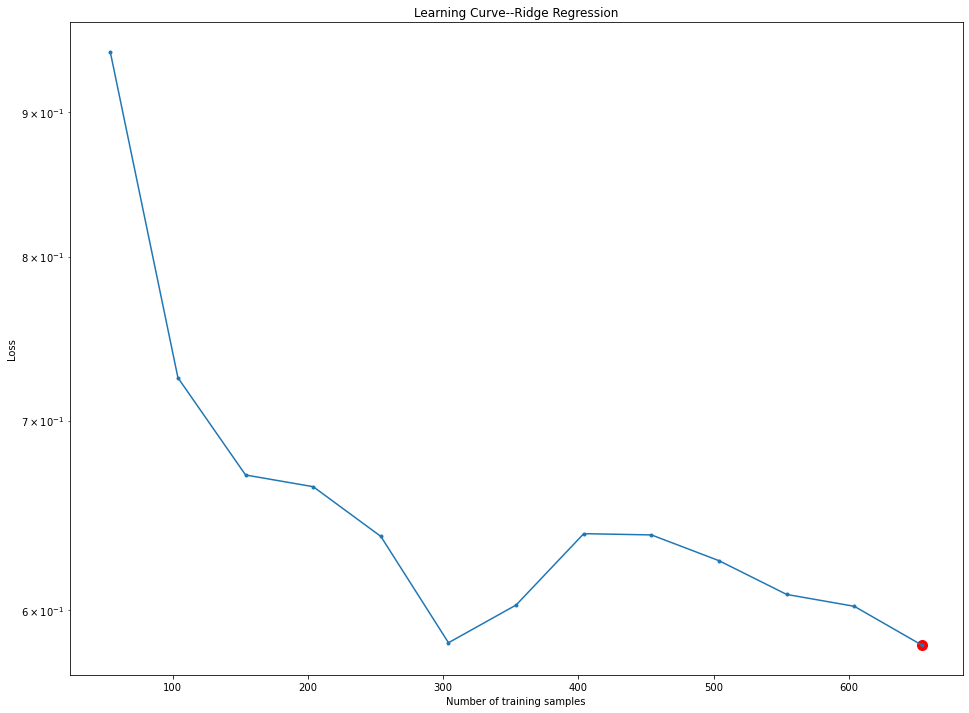

In [225]:
plt.figure(figsize=(16, 12))
plt.plot(numbers_train,losses_rr,'.-')
plt.scatter(optimal_n_train_rr, min_loss_rr, s = 100,marker='o', color='r')
plt.xlabel('Number of training samples')
plt.yscale('log')
plt.ylabel('Loss')
#plt.legend()
plt.title('Learning Curve--'+'Ridge Regression')
plt.show()

## Kernel Ridge Regression

### Optimization

#### Optimization of gamma

In [240]:
%%time
gammas =  np.logspace(0, 3, 23)
losses_krr_gamma = np.zeros((len(gammas)))
kernel_params = {"kernel": "rbf", "gamma": 1.0}
for i,gamma in enumerate(gammas):
    kernel_params["gamma"] = gamma
    krr = KernelRidge(alpha = 1e-6, **kernel_params)
    krr.fit(T_train, Y_train)
    Y_pred = krr.predict(T_valid)
    loss = error(Y_valid, Y_pred)
    losses_krr_gamma[i] = loss
    print(gamma)

1.0
1.368874509537081
1.8738174228603839
2.5650209056800453
3.511191734215131
4.8063808630643905
6.579332246575679
9.006280202112784
12.32846739442066
16.87612475788147
23.101297000831593
31.622776601683793
43.28761281083057
59.25530975545674
81.11308307896869
111.03363181676379
151.99110829529332
208.05675382171694
284.8035868435799
389.8603702549072
533.6699231206308
730.5271542664449
1000.0
CPU times: user 876 ms, sys: 32 ms, total: 908 ms
Wall time: 228 ms


In [241]:
optimal_index_gamma_krr = np.unravel_index(losses_krr_gamma.argmin(), losses_krr_gamma.shape)
optimal_gamma_krr = gammas[optimal_index_gamma_krr]
print("Optimal gamma for KRR with importance is {} ".format(optimal_gamma_krr))

Optimal gamma for KRR with importance is 533.6699231206308 


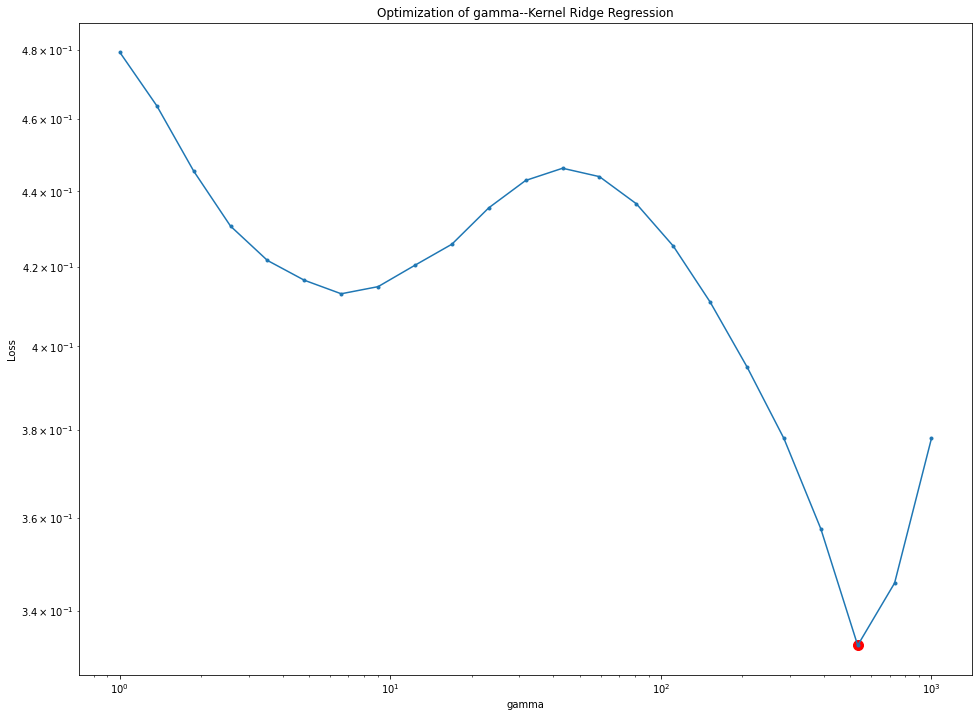

In [242]:
plt.figure(figsize=(16, 12))
plt.plot(gammas,losses_krr_gamma,'.-')
plt.scatter(optimal_gamma_krr, losses_krr_gamma[optimal_index_gamma_krr], s = 100,marker='o', color='r')
plt.xlabel('gamma')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Loss')
#plt.legend()
plt.title('Optimization of gamma--'+'Kernel Ridge Regression')
plt.show()

#### Optimization of alpha

In [243]:
%%time
alphas =  np.logspace(-10, 1, 23)
losses_krr_alpha = np.zeros((len(alphas)))
kernel_params = {"kernel": "rbf", "gamma": optimal_gamma_krr}
for i,alpha in enumerate(alphas):
    krr = KernelRidge(alpha = alpha, **kernel_params)
    krr.fit(T_train, Y_train)
    Y_pred = krr.predict(T_valid)
    loss = error(Y_valid, Y_pred)
    losses_krr_alpha[i] = loss
    print(alpha)

1e-10
3.1622776601683795e-10
1e-09
3.1622776601683795e-09
1e-08
3.162277660168379e-08
1e-07
3.162277660168379e-07
1e-06
3.162277660168379e-06
1e-05
3.1622776601683795e-05
0.0001
0.00031622776601683794
0.001
0.0031622776601683794
0.01
0.03162277660168379
0.1
0.31622776601683794
1.0
3.1622776601683795
10.0
CPU times: user 883 ms, sys: 28.1 ms, total: 911 ms
Wall time: 230 ms


In [244]:
optimal_index_alpha_krr = np.unravel_index(losses_krr_alpha.argmin(), losses_krr_alpha.shape)
optimal_alpha_krr = alphas[optimal_index_alpha_krr]
print("Optimal alpha for KRR with importance is {} ".format(optimal_alpha_krr))

Optimal alpha for KRR with importance is 0.00031622776601683794 


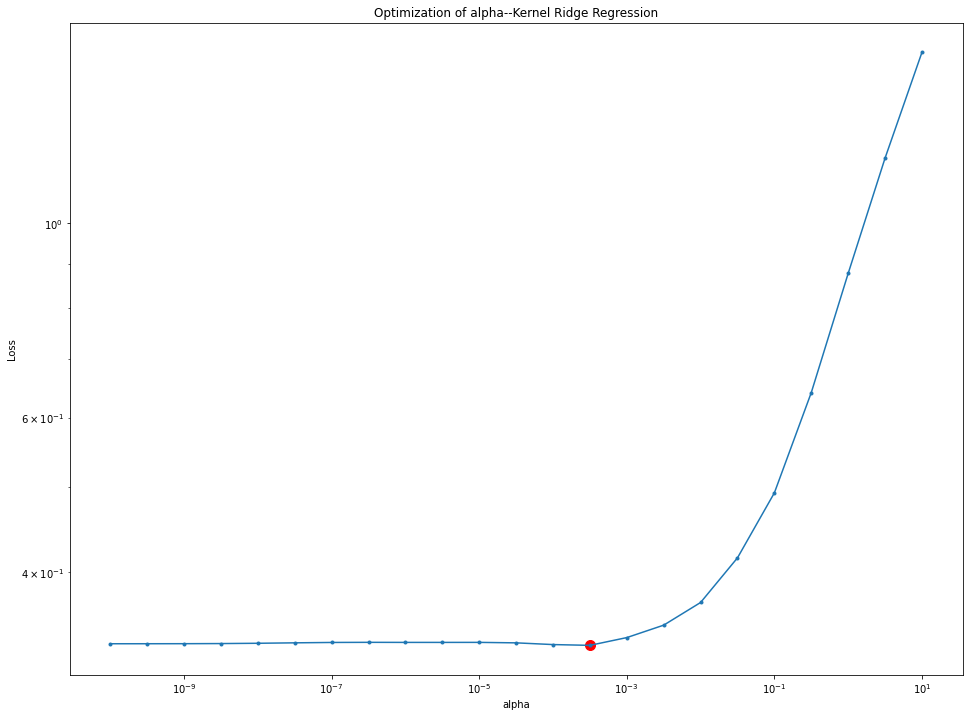

In [245]:
plt.figure(figsize=(16, 12))
plt.plot(alphas,losses_krr_alpha,'.-')
plt.scatter(optimal_alpha_krr, losses_krr_alpha[optimal_index_alpha_krr], s = 100,marker='o', color='r')
plt.xlabel('alpha')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Loss')
#plt.legend()
plt.title('Optimization of alpha--'+'Kernel Ridge Regression')
plt.show()

### Learning Curve

In [246]:
best_krr = KernelRidge(alpha = optimal_alpha_krr, **kernel_params)
numbers_train = np.arange(54,655,50)
losses_krr = np.zeros((len(numbers_train)))

In [247]:
%%time
for i,n in enumerate(numbers_train):
    Tt_train = T_ltrain[:n]
    Yt_train = Y_ltrain[:n]
    best_krr.fit(Tt_train,Yt_train)
    Y_pred = best_krr.predict(T_test)
    loss = error(Y_test, Y_pred)
    losses_krr[i] = loss
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
CPU times: user 460 ms, sys: 15.8 ms, total: 475 ms
Wall time: 119 ms


In [248]:
losses_krr

array([0.88306121, 0.60347756, 0.53473004, 0.47177654, 0.45007701,
       0.40372208, 0.37090318, 0.38670149, 0.37113106, 0.3606198 ,
       0.33719766, 0.33619622, 0.31187118])

In [249]:
optimal_index_loss_krr = np.unravel_index(losses_krr.argmin(), losses_krr.shape)
optimal_n_train_krr = numbers_train[optimal_index_loss_krr]
min_loss_krr = losses_krr[optimal_index_loss_krr]
print("Minimum loss of KRR with importance selector is {} when number of train is {}  ".format(min_loss_krr,optimal_n_train_krr))

Minimum loss of KRR with importance selector is 0.31187117683429116 when number of train is 654  


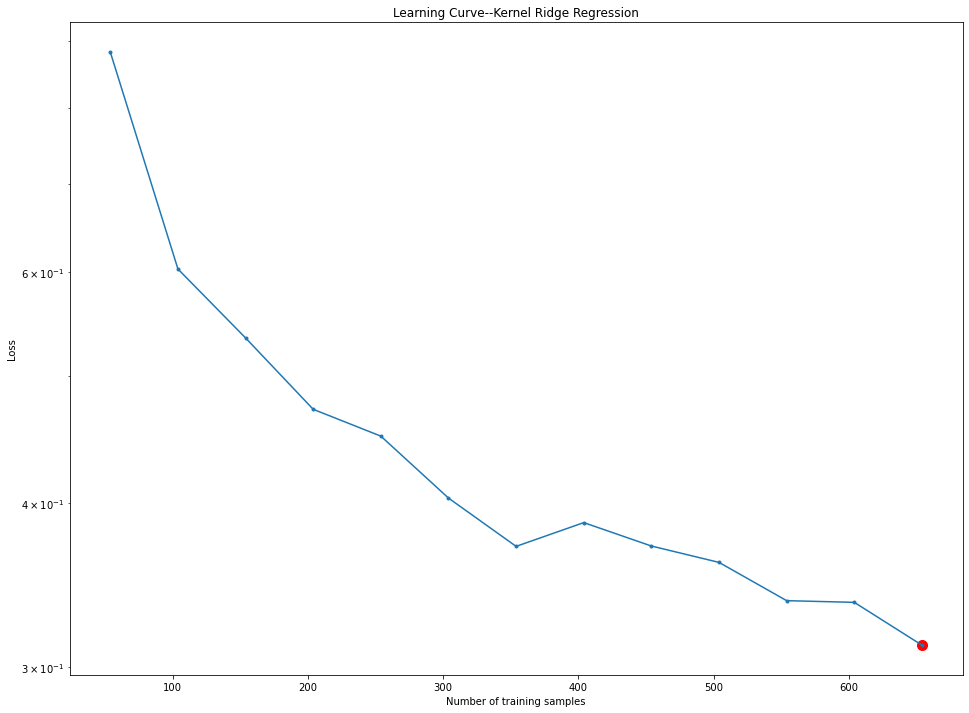

In [250]:
plt.figure(figsize=(16, 12))
plt.plot(numbers_train,losses_krr,'.-')
plt.scatter(optimal_n_train_krr, min_loss_krr, s = 100,marker='o', color='r')
plt.xlabel('Number of training samples')
plt.yscale('log')
plt.ylabel('Loss')
#plt.legend()
plt.title('Learning Curve--'+'Kernel Ridge Regression')
plt.show()

### Summary

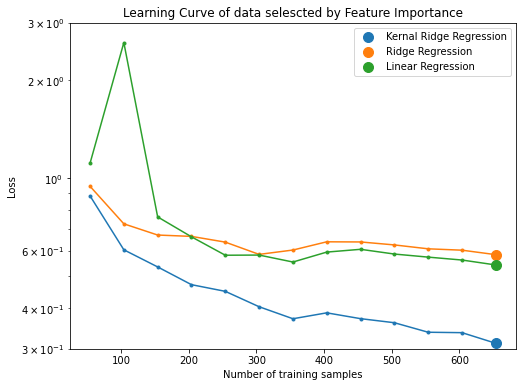

In [286]:
plt.figure(figsize=(8, 6))
plt.plot(numbers_train,losses_krr,'.-')
plt.scatter(optimal_n_train_krr, min_loss_krr, s = 100,marker='o',label='Kernal Ridge Regression')
plt.plot(numbers_train,losses_rr,'.-')
plt.scatter(optimal_n_train_rr, min_loss_rr, s = 100,marker='o',label='Ridge Regression')
plt.plot(numbers_train,losses_lr,'.-')
plt.scatter(optimal_n_train_lr, min_loss_lr, s = 100,marker='o',label='Linear Regression')

plt.xlabel('Number of training samples')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0.3, 3)
plt.title('Learning Curve of data selescted by Feature Importance')
plt.savefig('Importance.png')
plt.show()